Median Age: 74.25


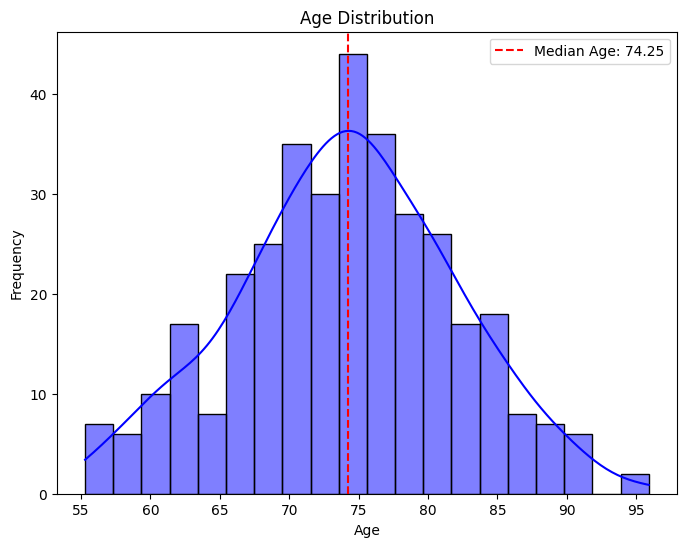

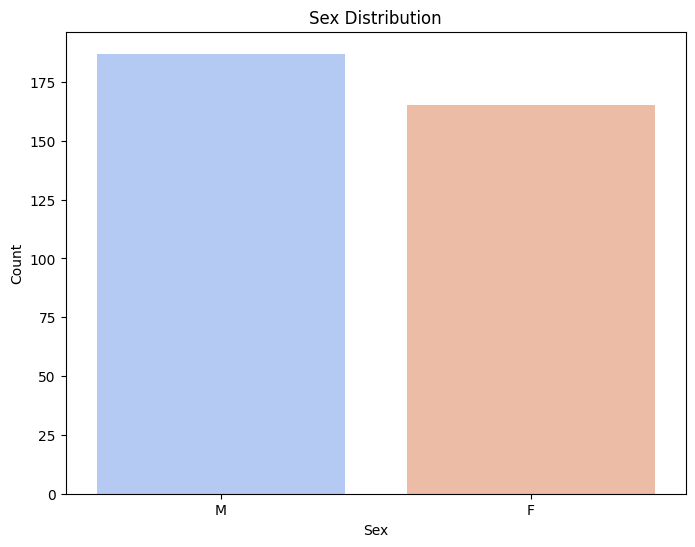

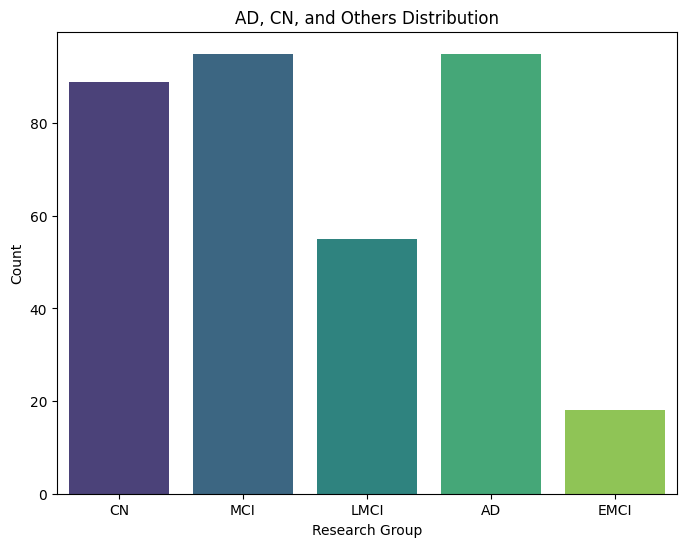

Sex             F   M
ResearchGroup        
AD             40  55
CN             52  37
EMCI            8  10
LMCI           23  32
MCI            42  53
AD_men: 55 subjects
AD_women: 40 subjects
CN_men: 37 subjects
CN_women: 52 subjects
Other_men: 95 subjects
Other_women: 73 subjects
Train set: 244 subjects
Validation set: 50 subjects
Test set: 58 subjects


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
project_dir = '/home/santiago/Desktop/azheimer/'  # Adjust to your path
csv_path = os.path.join(project_dir, 'DataBaseSubjects.csv')
tensor_data_dir = os.path.join(project_dir, 'TensorData')

# Load the CSV file
subjects_df = pd.read_csv(csv_path)

# Calculate the median age and print it
median_age = subjects_df['Age'].median()
print(f"Median Age: {median_age}")

# Plot the age distribution
plt.figure(figsize=(8, 6))
sns.histplot(subjects_df['Age'], bins=20, kde=True, color='blue')
plt.axvline(median_age, color='red', linestyle='--', label=f'Median Age: {median_age}')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the sex distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', data=subjects_df, palette='coolwarm')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot the distribution of AD, CN, and Others
plt.figure(figsize=(8, 6))
sns.countplot(x='ResearchGroup', data=subjects_df, palette='viridis')
plt.title('AD, CN, and Others Distribution')
plt.xlabel('Research Group')
plt.ylabel('Count')
plt.show()

# Group subjects by Research Group and Sex
grouped_data = subjects_df.groupby(['ResearchGroup', 'Sex']).size().unstack().fillna(0)
print(grouped_data)

# Initialize dictionaries for storing tensor paths by group and sex
tensor_groups = {
    'AD_men': [],
    'AD_women': [],
    'CN_men': [],
    'CN_women': [],
    'Other_men': [],
    'Other_women': []
}

# Iterate over subjects and assign tensors to groups
for subject_id in subjects_df['SubjectID']:
    group = subjects_df[subjects_df['SubjectID'] == subject_id]['ResearchGroup'].values[0]
    sex = subjects_df[subjects_df['SubjectID'] == subject_id]['Sex'].values[0]
    file_name = f'{group}_tensor_{subject_id}.pt'
    file_path = os.path.join(tensor_data_dir, file_name)
    
    if os.path.exists(file_path):
        if group == 'AD':
            if sex == 'M':
                tensor_groups['AD_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['AD_women'].append(file_path)
        elif group == 'CN':
            if sex == 'M':
                tensor_groups['CN_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['CN_women'].append(file_path)
        else:  # Others
            if sex == 'M':
                tensor_groups['Other_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['Other_women'].append(file_path)

# Print the number of subjects in each group
for key, value in tensor_groups.items():
    print(f'{key}: {len(value)} subjects')

# Split data into train, validation, and test sets with equal proportions
def split_data(tensors, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    np.random.shuffle(tensors)
    n_total = len(tensors)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_set = tensors[:n_train]
    val_set = tensors[n_train:n_train + n_val]
    test_set = tensors[n_train + n_val:]
    
    return train_set, val_set, test_set

# Initialize lists for train, validation, and test sets
train_set, val_set, test_set = [], [], []

# Combine groups ensuring equal proportions of gender and research groups
for group in tensor_groups:
    train, val, test = split_data(tensor_groups[group])
    train_set.extend(train)
    val_set.extend(val)
    test_set.extend(test)

# Print final counts of train, validation, and test sets
print(f"Train set: {len(train_set)} subjects")
print(f"Validation set: {len(val_set)} subjects")
print(f"Test set: {len(test_set)} subjects")




In [4]:
# Load the tensors and create datasets
def load_tensors(file_paths):
    tensors = []
    for fp in file_paths:
        data = torch.load(fp)
        if isinstance(data, np.ndarray):  # Convert numpy arrays to tensors
            data = torch.tensor(data)
        tensors.append(data)
        # Print the dimensions of the loaded tensor
        #print(f"Loaded tensor from {fp}, shape: {data.shape}")
    return torch.stack(tensors)

# Load data for train, validation, and test sets
train_data = load_tensors(train_set)
val_data = load_tensors(val_set)
test_data = load_tensors(test_set)

# Print final dataset shapes
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: torch.Size([244, 3, 116, 116])
Validation data shape: torch.Size([50, 3, 116, 116])
Test data shape: torch.Size([58, 3, 116, 116])
Datasets have been constructed with equal proportions.


Plotting matrices for a random subject from Train dataset: /home/santiago/Desktop/azheimer/TensorData/AD_tensor_057_S_6746.pt


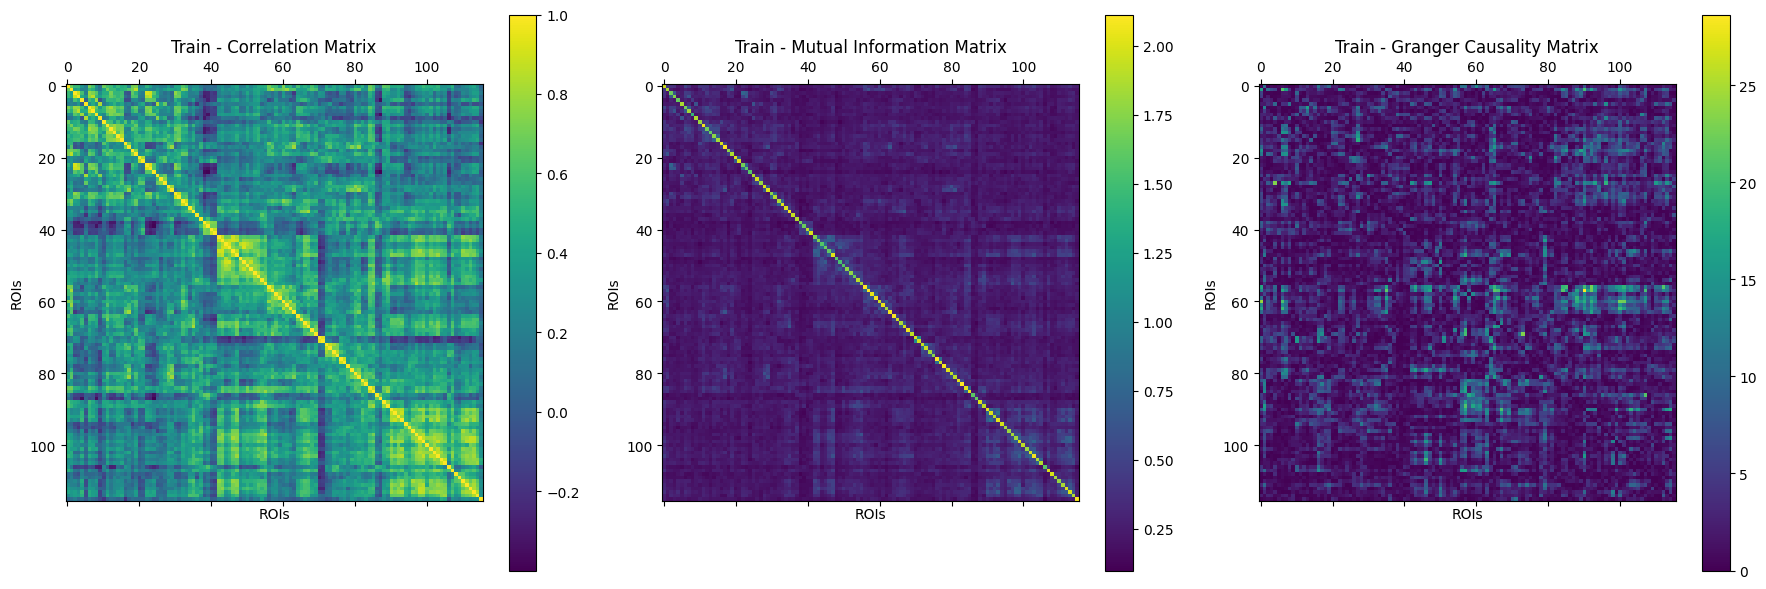

Plotting matrices for a random subject from Validation dataset: /home/santiago/Desktop/azheimer/TensorData/MCI_tensor_130_S_6646.pt


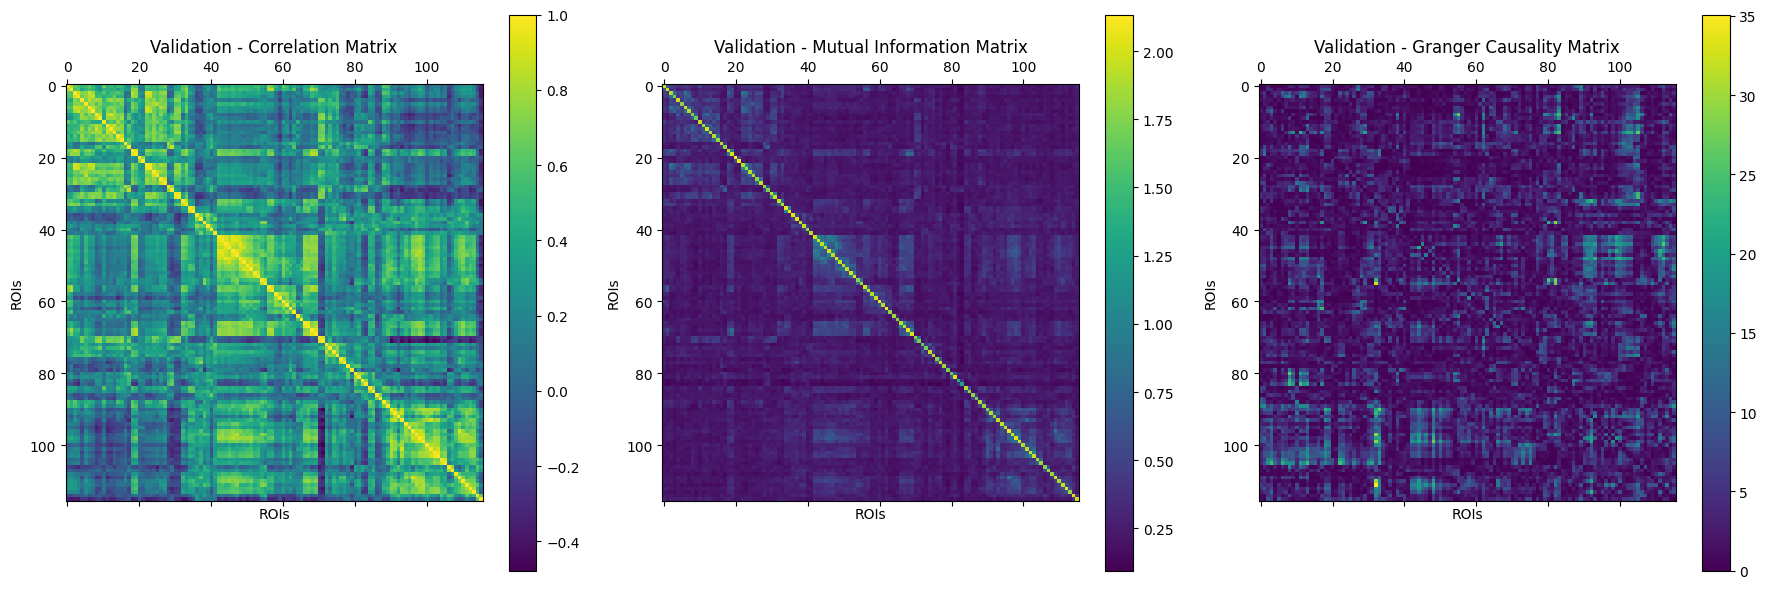

Plotting matrices for a random subject from Test dataset: /home/santiago/Desktop/azheimer/TensorData/LMCI_tensor_130_S_4817.pt


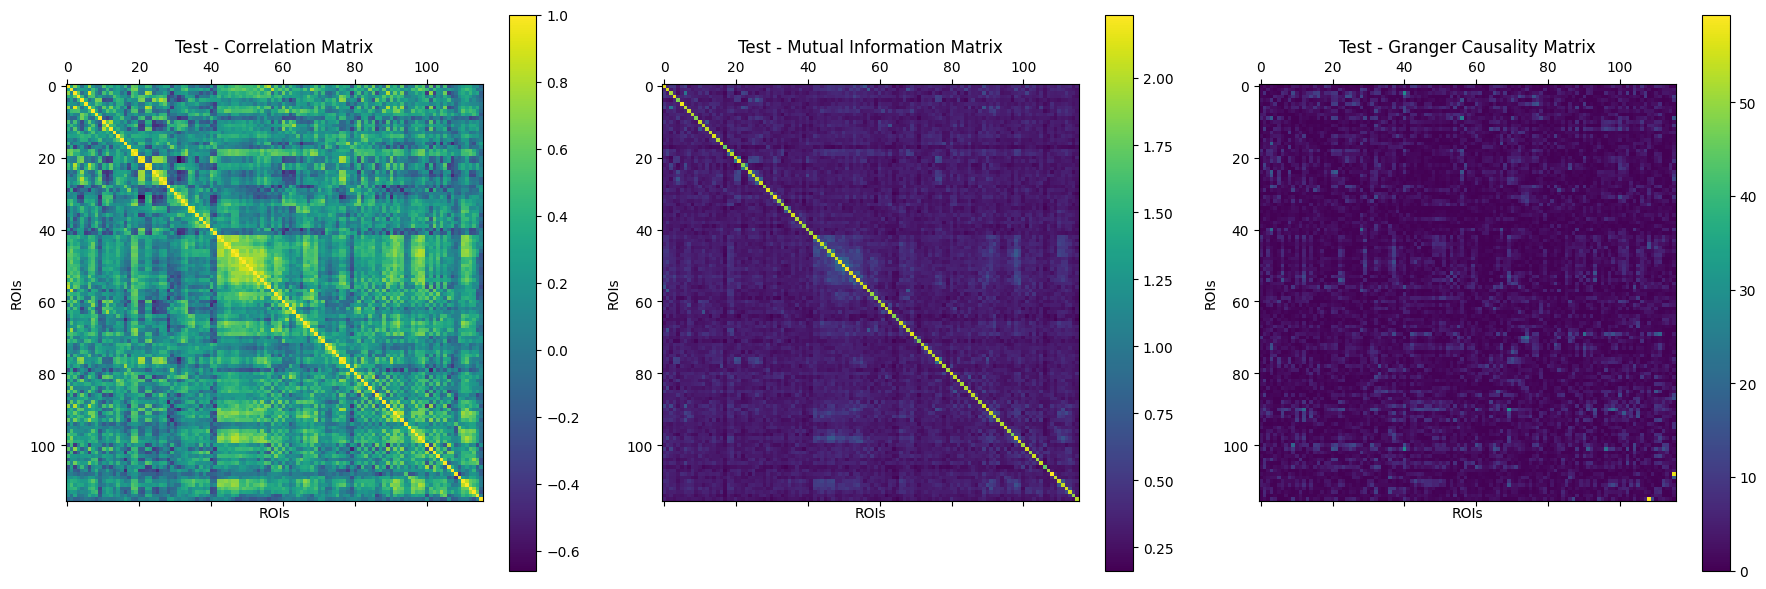

In [5]:
import random
import matplotlib.pyplot as plt

# Function to plot the three matrices for a given subject's tensor
def plot_matrices(tensor, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    matrix_titles = ['Correlation Matrix', 'Mutual Information Matrix', 'Granger Causality Matrix']

    # Loop through the three matrices
    for i in range(3):
        ax = axes[i]
        cax = ax.matshow(tensor[i], cmap='viridis')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'{title_prefix} - {matrix_titles[i]}')
        ax.set_xlabel('ROIs')
        ax.set_ylabel('ROIs')

    plt.tight_layout()
    plt.show()

# Choose a random subject from each dataset and plot their matrices
def plot_random_subject_from_dataset(dataset, dataset_name):
    random_subject = random.choice(dataset)
    print(f"Plotting matrices for a random subject from {dataset_name} dataset: {random_subject}")
    
    # Load the tensor for the randomly selected subject
    tensor = torch.load(random_subject)
    
    # Plot the matrices
    plot_matrices(tensor, dataset_name)

# Plot one random subject from train, validation, and test datasets
plot_random_subject_from_dataset(train_set, 'Train')
plot_random_subject_from_dataset(val_set, 'Validation')
plot_random_subject_from_dataset(test_set, 'Test')
